# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%config InlineBackend.figure_formats = ['svg']

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from scipy.sparse import csr_matrix
import time
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/MMP/Projects/prac2

/content/drive/MyDrive/MMP/Projects/prac2


In [5]:
import optimization
import oracles
import utils

# Data

In [6]:
train_df = pd.read_csv('data/toxic_train.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('data/toxic_test.csv', index_col='Unnamed: 0')
print(train_df.shape)
print(test_df.shape)

(52061, 2)
(20676, 2)


In [7]:
test_df.iloc[2779]['comment_text']

"== Remove all the refs from the lede == \n If someone doesn't do this by Tuesday evening, I will unless there are objections."

# Experiments

## 1

In [8]:
from sklearn.pipeline import Pipeline
import re

class TextProccessing():
    def __init__(self):
        pass

    def transform(self, input_df, **transform_params):
        transformed_df = input_df.copy()
        transformed_df['comment_text'] = np.array([s.lower() for s in transformed_df['comment_text']])
        transformed_df['comment_text'] = np.array([re.sub('\W', ' ', s) for s in transformed_df['comment_text']])
        transformed_df['comment_text'] = np.array([' '.join(s.split()) for s in transformed_df['comment_text']])
        return transformed_df

    def fit(self, X, y=None, **fit_params):
        return self

pipeline = Pipeline([
    ("lowercase", TextProccessing())
])

In [9]:
train_df = pipeline.fit_transform(train_df)
test_df = pipeline.transform(test_df)

In [10]:
test_df.iloc[2779]['comment_text']

'remove all the refs from the lede if someone doesn t do this by tuesday evening i will unless there are objections'

## 2

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.001)
# было до min_df: 91839, стало после: 3724

In [12]:
vectorizer.fit(train_df['comment_text'])
X_train = vectorizer.transform(train_df['comment_text'])
X_val = vectorizer.transform(test_df['comment_text'])

y_train = np.array(train_df['is_toxic'].astype(int))
y_val = np.array(test_df['is_toxic'].astype(int))
y_train[y_train == 0] = -1
y_val[y_val == 0] = -1

## 3

In [23]:
params = {
    'max_iter': 10,
    'l2_coef': 0.01,
}

### step_alpha

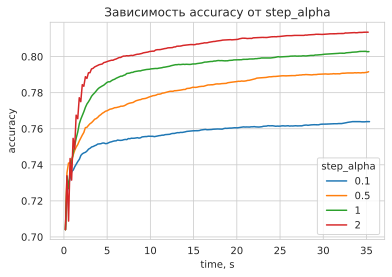

In [27]:
alphas = [0.1, 0.5, 1, 2]
for a in alphas:
    clf = optimization.GDClassifier(**params, step_alpha=a, step_beta=0.5)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=np.cumsum(history['time'][1:]), y=history['accuracy'][1:], label=str(a))
plt.title('Зависимость accuracy от step_alpha')
plt.xlabel('time, s')
plt.ylabel('accuracy')
plt.legend(title="step_alpha")
plt.savefig('3_step_alpha_accuracy_time.pdf')
plt.show()

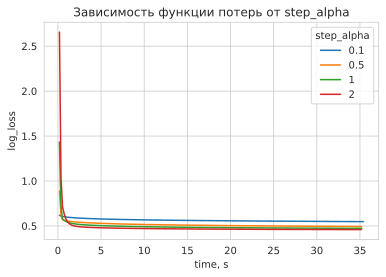

In [28]:
for a in alphas:
    clf = optimization.GDClassifier(**params, step_alpha=a, step_beta=0.5)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=np.cumsum(history['time'][1:]), y=history['func'][1:], label=str(a))
plt.title('Зависимость функции потерь от step_alpha')
plt.xlabel('time, s')
plt.ylabel('log_loss')
plt.legend(title="step_alpha")
plt.savefig('3_step_alpha_loss_time.pdf')
plt.show()

### step_beta

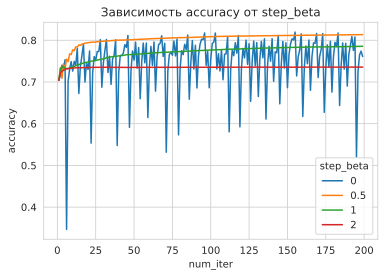

In [ ]:
betas = [0, 0.5, 1, 2]
for b in betas:
    clf = optimization.GDClassifier(**params, step_alpha=2, step_beta=b)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['accuracy']))[1:], y=history['accuracy'][1:], label=str(b))
plt.title('Зависимость accuracy от step_beta')
plt.xlabel('num_iter')
plt.ylabel('accuracy')
plt.legend(title="step_beta")
plt.savefig('3_step_beta_accuracy_iter.pdf')
plt.show()

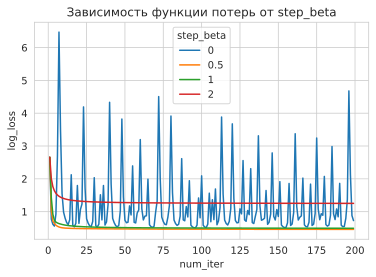

In [ ]:
for b in betas:
    clf = optimization.GDClassifier(**params, step_alpha=2, step_beta=b)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['func']))[1:], y=history['func'][1:], label=str(b))
plt.title('Зависимость функции потерь от step_beta')
plt.xlabel('num_iter')
plt.ylabel('log_loss')
plt.legend(title="step_beta")
plt.savefig('3_step_beta_loss_iter.pdf')
plt.show()

### start weights

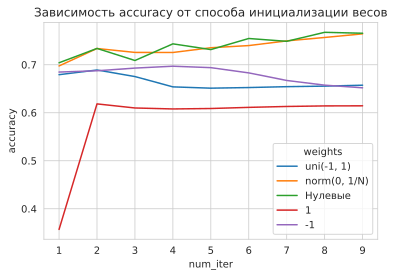

In [18]:
w0s = {
    'uni(-1, 1)': np.random.uniform(-1, 1, X_train.shape[1]),
    'norm(0, 1/N)': np.random.normal(0.001, 1/X_train.shape[1], X_train.shape[1]),
    'Нулевые': np.zeros(X_train.shape[1]),
    '1': np.ones(X_train.shape[1]),
    '-1': np.ones(X_train.shape[1])*(-1),
    }
for name, w_0 in zip(w0s.keys(), w0s.values()):
    clf = optimization.GDClassifier(**params, step_alpha=2, step_beta=0.5)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True, w_0=w_0)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['accuracy']))[1:], y=history['accuracy'][1:], label=name)
plt.title('Зависимость accuracy от способа инициализации весов')
plt.xlabel('num_iter')
plt.ylabel('accuracy')
plt.legend(title="weights")
plt.savefig('3_weights_accuracy_iter.pdf')
plt.show()

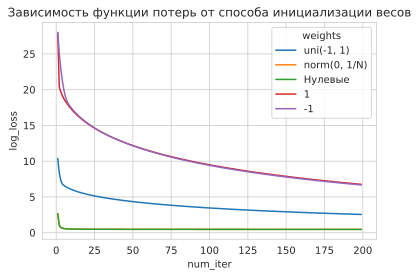

In [ ]:
for name, w_0 in zip(w0s.keys(), w0s.values()):
    clf = optimization.GDClassifier(**params, step_alpha=2, step_beta=0.5)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True, w_0=w_0)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['func']))[1:], y=history['func'][1:], label=name, markers=True)
plt.title('Зависимость функции потерь от способа инициализации весов')
plt.xlabel('num_iter')
plt.ylabel('log_loss')
plt.legend(title="weights")
plt.savefig('3_weights_loss_iter.pdf')
plt.show()

## 4

In [ ]:
params = {
    'max_iter': 6000,
    'l2_coef': 0.01,
}

### step_alpha

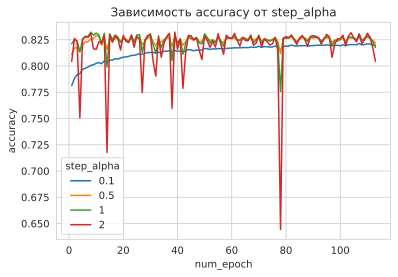

In [ ]:
alphas = [0.1, 0.5, 1, 2]
for a in alphas:
    clf = optimization.SGDClassifier(**params, step_alpha=a, step_beta=0.5, batch_size=1000)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['accuracy']))[1:], y=history['accuracy'][1:], label=str(a))
plt.title('Зависимость accuracy от step_alpha')
plt.xlabel('num_epoch')
plt.ylabel('accuracy')
plt.legend(title="step_alpha")
plt.savefig('4_step_alpha_accuracy_epoch.pdf')
plt.show()

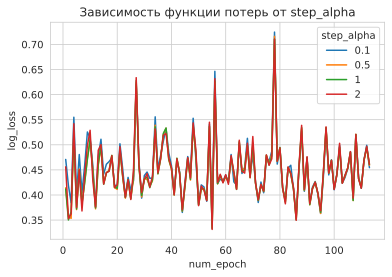

In [ ]:
for a in alphas:
    clf = optimization.SGDClassifier(**params, step_alpha=a, step_beta=0.5, batch_size=1000)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['func']))[1:], y=history['func'][1:], label=str(a))
plt.title('Зависимость функции потерь от step_alpha')
plt.xlabel('num_epoch')
plt.ylabel('log_loss')
plt.legend(title="step_alpha")
plt.savefig('4_step_alpha_loss_epoch.pdf')
plt.show()

### step_beta

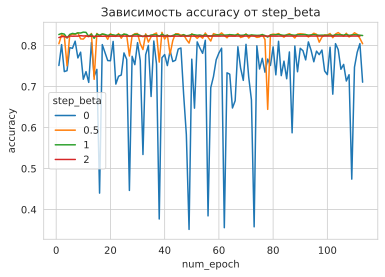

In [ ]:
betas = [0, 0.5, 1, 2]
for b in betas:
    clf = optimization.SGDClassifier(**params, step_alpha=2, step_beta=b, batch_size=1000)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['accuracy']))[1:], y=history['accuracy'][1:], label=str(b))
plt.title('Зависимость accuracy от step_beta')
plt.xlabel('num_epoch')
plt.ylabel('accuracy')
plt.legend(title="step_beta")
plt.savefig('4_step_beta_accuracy_epoch.pdf')
plt.show()

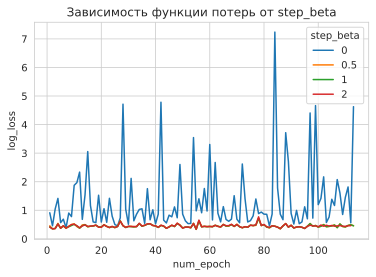

In [ ]:
for b in betas:
    clf = optimization.SGDClassifier(**params, step_alpha=2, step_beta=b, batch_size=1000)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['func']))[1:], y=history['func'][1:], label=str(b))
plt.title('Зависимость функции потерь от step_beta')
plt.xlabel('num_epoch')
plt.ylabel('log_loss')
plt.legend(title="step_beta")
plt.savefig('4_step_beta_loss_epoch.pdf')
plt.show()

### weights

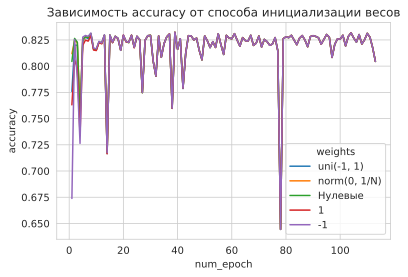

In [ ]:
w0s = {
    'uni(-1, 1)': np.random.uniform(-1, 1, X_train.shape[1]),
    'norm(0, 1/N)': np.random.normal(0.0, 1/X_train.shape[1], X_train.shape[1]),
    'Нулевые': np.zeros(X_train.shape[1]),
    '1': np.ones(X_train.shape[1]),
    '-1': np.ones(X_train.shape[1])*(-1),
    }
for name, w_0 in zip(w0s.keys(), w0s.values()):
    clf = optimization.SGDClassifier(**params, step_alpha=2, step_beta=0.5, batch_size=1000)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True, w_0=w_0)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['accuracy']))[1:], y=history['accuracy'][1:], label=name)
plt.title('Зависимость accuracy от способа инициализации весов')
plt.xlabel('num_epoch')
plt.ylabel('accuracy')
plt.legend(title="weights")
plt.savefig('4_weights_accuracy_epoch.pdf')
plt.show()

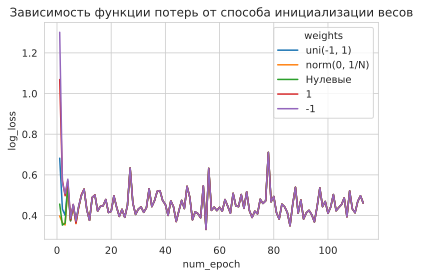

In [ ]:
for name, w_0 in zip(w0s.keys(), w0s.values()):
    clf = optimization.SGDClassifier(**params, step_alpha=2, step_beta=0.5, batch_size=1000)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True, w_0=w_0)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=range(len(history['func']))[1:], y=history['func'][1:], label=name, markers=True)
plt.title('Зависимость функции потерь от способа инициализации весов')
plt.xlabel('num_epoch')
plt.ylabel('log_loss')
plt.legend(title="weights")
plt.savefig('4_weights_loss_epoch.pdf')
plt.show()

### batch_size

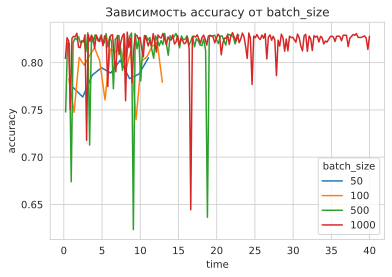

In [22]:
batch_sz = [50, 100, 500, 1000]
for bs in batch_sz:
    clf = optimization.SGDClassifier(max_iter=10000, l2_coef=0.01, step_alpha=2, step_beta=0.5, batch_size=bs)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=np.cumsum(history['time'][1:]), y=history['accuracy'][1:], label=str(bs))
plt.title('Зависимость accuracy от batch_size')
plt.xlabel('time, s')
plt.ylabel('accuracy')
plt.legend(title="batch_size")
plt.savefig('4_batch_size_accuracy_epoch.pdf')
plt.show()

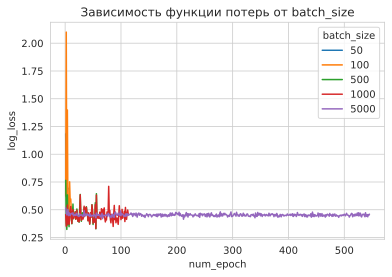

In [29]:
for bs in batch_sz:
    clf = optimization.SGDClassifier(**params, step_alpha=2, step_beta=0.5, batch_size=bs)
    history = clf.fit(X_train, y_train, X_val, y_val, trace=True)
    y_pred = clf.predict(X_val)
    sns.lineplot(x=np.cumsum(history['time'][1:]), y=history['func'][1:], label=str(bs))
plt.title('Зависимость функции потерь от batch_size')
plt.xlabel('time, s')
plt.ylabel('log_loss')
plt.legend(title="batch_size")
plt.savefig('4_batch_size_loss_epoch.pdf')
plt.show()

## 5

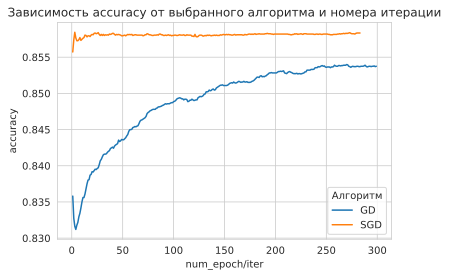

In [68]:
clf1 = optimization.GDClassifier(max_iter=300, l2_coef=0.01, step_alpha=1, step_beta=0.5)
history1 = clf1.fit(X_train, y_train, X_val, y_val, trace=True)
y_pred1 = clf1.predict(X_val)

clf2 = optimization.SGDClassifier(max_iter=15000, l2_coef=0.01, step_alpha=1, step_beta=1, batch_size=1000)
history2 = clf2.fit(X_train, y_train, X_val, y_val, trace=True)
y_pred2 = clf2.predict(X_val)

sns.lineplot(x=range(len(history1['accuracy']))[1:], y=history1['accuracy'][1:], label='GD')
sns.lineplot(x=range(len(history2['accuracy']))[1:], y=history2['accuracy'][1:], label='SGD')

plt.title('Зависимость accuracy от выбранного алгоритма и номера итерации')
plt.xlabel('num_epoch/iter')
plt.ylabel('accuracy')
plt.legend(title="Алгоритм")
plt.savefig('6_GD_vs_SGD.pdf')
plt.show()

## 6

In [30]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
class TextLemmatizer():
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def transform(self, input_df, **transform_params):
        transformed_df = input_df.copy()
        transformed_df['comment_text'] = np.array([' '.join([self.lemmatizer.lemmatize(s) for s in text.split()]) for text in transformed_df['comment_text']])
        return transformed_df
    def fit(self, X, y=None, **fit_params):
        return self

class TextStopWords():
    def __init__(self):
        self.stop_words = list(stopwords.words('english')) #About 150 stopwords
    def transform(self, input_df, **transform_params):
        transformed_df = input_df.copy()
        transformed_df['comment_text'] = np.array([' '.join([w for w in text.split(' ') if not w in self.stop_words]) for text in transformed_df['comment_text']])
        return transformed_df['comment_text'] # <- потому что последний типа
    def fit(self, X, y=None, **fit_params):
        return self

pipeline = Pipeline([
    ('lowercase', TextProccessing()),
    ('lemmatization', TextLemmatizer()),
    ('stop-words', TextStopWords()),
    ('vectorizer', CountVectorizer(min_df=1e-05))
])

In [32]:
train_df = pd.read_csv('data/toxic_train.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('data/toxic_test.csv', index_col='Unnamed: 0')
print(train_df.sample(3))
X_train = pipeline.fit_transform(train_df)
X_val = pipeline.transform(test_df)
print(X_train.shape[1])
#X_train = vectorizer.fit_transform(train_df['comment_text'])
#X_val = vectorizer.transform(test_df['comment_text'])

y_train = np.array(train_df['is_toxic'].astype(int))
y_val = np.array(test_df['is_toxic'].astype(int))
y_train[y_train == 0] = -1
y_val[y_val == 0] = -1

                                            comment_text  is_toxic
30657  Bring it on, see you before Remember the dot o...     False
11625     "\nI meant to say, Jolly good job!  · (talk) "     False
15959  "/08)\n\nThe definition of ""injury"" certainl...     False
85340


In [33]:
#Сюда потом нужно засунуть лучшие параметры
clf = optimization.SGDClassifier(max_iter=30000, l2_coef=0.01, step_alpha=1, step_beta=1, batch_size=1000)
st = time.time()
clf.fit(X_train, y_train, trace=False)
y_pred = clf.predict(X_val)
accuracy_score(y_val, y_pred), time.time() - st

(0.8494389630489456, 205.45953345298767)

`SGDClassifier(max_iter=3000, l2_coef=0.1, step_alpha=0.5, step_beta=1, batch_size=1000)` <br>
lowercase: 0.7880150899593732 <br>
lowercase+lemmatization: 0.7880150899593732 <br>
lowercase+lemmatization+stop-words: 0.836912362159025

## 7

In [34]:
train_df = pd.read_csv('data/toxic_train.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('data/toxic_test.csv', index_col='Unnamed: 0')

y_train = np.array(train_df['is_toxic'].astype(int))
y_val = np.array(test_df['is_toxic'].astype(int))
y_train[y_train == 0] = -1
y_val[y_val == 0] = -1

pipeline = Pipeline([
    ('lowercase', TextProccessing()),
    ('lemmatization', TextLemmatizer()),
    ('stop-words', TextStopWords()),
])
train_df = pipeline.fit_transform(train_df)
test_df = pipeline.transform(test_df)

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = CountVectorizer(min_df=0.0001)
X_train = vectorizer.fit_transform(train_df)
X_val = vectorizer.transform(test_df)

clf = optimization.SGDClassifier(max_iter=1000, l2_coef=0.01, step_alpha=1, step_beta=1, batch_size=1000)
clf.fit(X_train, y_train, trace=False)
y_pred = clf.predict(X_val)
print(f'bag_of_words, acc: {accuracy_score(y_val, y_pred)}')
print(f'n after bag_of_words: {X_train.shape[1]}')

vectorizer = TfidfVectorizer(min_df=0.0001)
X_train = vectorizer.fit_transform(train_df)
X_val = vectorizer.transform(test_df)

clf = optimization.SGDClassifier(max_iter=1000, l2_coef=0.01, step_alpha=1, step_beta=1, batch_size=1000)
clf.fit(X_train, y_train, trace=False)
y_pred = clf.predict(X_val)
print(f'tfidf, acc: {accuracy_score(y_val, y_pred)}')
print(f'n after tfidf: {X_train.shape[1]}')

bag_of_words, acc: 0.8437318630295996
n after bag_of_words: 15848
tfidf, acc: 0.8173244341265236
n after tfidf: 15848


In [37]:
# min_dfs = [0.00001, 0.0001, 0.01]
# for md in min_dfs:
#     vectorizer = CountVectorizer(min_df=md)
#     X_train = vectorizer.fit_transform(train_df)
#     X_val = vectorizer.transform(test_df)
#     clf = optimization.SGDClassifier(max_iter=1000, l2_coef=0.01, step_alpha=1, step_beta=1, batch_size=1000)
#     clf.fit(X_train, y_train, trace=False)
#     y_pred = clf.predict(X_val)
#     print(f'min_df: {md}, acc: {accuracy_score(y_val, y_pred)}, n_weights: {X_train.shape[1]}')

# print('###')
max_dfs = [0.8, 0.3, 0.1, 0.05, 0.001]
for md in max_dfs:
    vectorizer = CountVectorizer(min_df=1e-4, max_df=md)
    X_train = vectorizer.fit_transform(train_df)
    X_val = vectorizer.transform(test_df)
    clf = optimization.SGDClassifier(max_iter=1000, l2_coef=0.01, step_alpha=1, step_beta=1, batch_size=1000)
    clf.fit(X_train, y_train, trace=False)
    y_pred = clf.predict(X_val)
    print(f'max_df: {md}, acc: {accuracy_score(y_val, y_pred)}, n_weights: {X_train.shape[1]}')

max_df: 0.8, acc: 0.8447958986264268, n_weights: 14246
max_df: 0.3, acc: 0.8447958986264268, n_weights: 14246
max_df: 0.1, acc: 0.8516637647514026, n_weights: 14236
max_df: 0.05, acc: 0.8569355774811376, n_weights: 14208
max_df: 0.001, acc: 0.5642290578448442, n_weights: 10852


## 8

In [39]:
pipeline = Pipeline([
    ('lowercase', TextProccessing()),
    #('lemmatization', TextLemmatizer()),
    ('stop-words', TextStopWords()),
    ('vectorizer', CountVectorizer(min_df=1e-4, max_df=0.05))
])
train_df = pd.read_csv('data/toxic_train.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('data/toxic_test.csv', index_col='Unnamed: 0')

X_train = pipeline.fit_transform(train_df)
X_val = pipeline.transform(test_df)


y_train = np.array(train_df['is_toxic'].astype(int))
y_val = np.array(test_df['is_toxic'].astype(int))
y_train[y_train == 0] = -1
y_val[y_val == 0] = -1

In [40]:
clf = optimization.SGDClassifier(max_iter=10000, l2_coef=0.01, step_alpha=1, step_beta=1, batch_size=1000)
clf.fit(X_train, y_train, trace=False)
y_pred = clf.predict(X_val)
print(f'acc: {accuracy_score(y_val, y_pred)}')

acc: 0.8546624105242794


In [46]:
test_df[y_pred==0]

,comment_text,is_toxic
5,this other one from 1897,False
16,일이삼사오육칠팔구하고십이요 에헤헤 으헤 으헤 으허허,False
39,aapn bhtla aanand jhala..,False
54,السلام عليكم و رحمة الله و بركاته الا الجميع \...,False
60,== hrthrtdghrsdtghtrsdhtrhdgthjrtgh == \n\n ff...,False
...,...,...
50837,YOU ARE A GODDNED FGT!YOU ARE A GODDNED FGT!YO...,True
53702,"No, and you're a lamer",True
54728,F U C K o F F \n ANSTOP BOTHERIN ME FAGOT,True
57321,FFFFFFFFFFFFFFFFFFFFFFFUUUUUUUUUUUUUUUUUUUUUUU...,True


In [45]:
y_pred[y_pred == 0].shape

(293,)

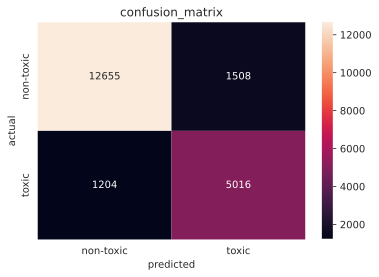

In [68]:
from sklearn.metrics import confusion_matrix
y_val = y_val[y_pred!=0]
y_pred = y_pred[y_pred!=0]
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='', yticklabels=['non-toxic', 'toxic'], xticklabels=['non-toxic', 'toxic'])
plt.xlabel('predicted')
plt.title('confusion_matrix')
plt.ylabel('actual')
plt.savefig('cf.pdf')

In [67]:
y_val[(y_pred == 1) & (y_val==-1)].shape

(1508,)

In [54]:
train_df['is_toxic'].value_counts()

False    35836
True     16225
Name: is_toxic, dtype: int64

# Debuging

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

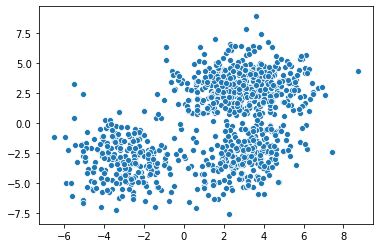

In [ ]:
X, y = make_classification(n_samples=1000, n_features=6, n_informative=6, n_redundant=0, class_sep=3)
sns.scatterplot(x=X[:, 0], y=X[:, 1])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.33, random_state=42)
plt.show()

In [ ]:
X_train1 = scipy.sparse.csr_matrix(X_train1)
X_test1 = scipy.sparse.csr_matrix(X_test1)
clf = optimization.GDClassifier(max_iter=1000, l2_coef=0, step_alpha=0.1, step_beta=0)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
accuracy_score(y_pred, y_test1)

0.48484848484848486

In [ ]:
y_pred_proba = clf.predict_proba(X_test1)
y_pred_proba.mean()

0.8065229423236837

In [ ]:
def fit(self, X, y, Xt, Yt, w_0=None, trace=False):
        ls = np.shape(y)[0]
        if w_0 is None:
            w_0 = np.zeros((ls))
        BL = BinaryLogistic(**self.kwargs)
        if trace:
            history = {}
            history['time'] = []
            history['func'] = []
            history['accuracy'] = []
            w = w_0
            f_st = BL.func(X, y, w)
            history['func'].append(round(f_st, 15))
            history['time'].append(0)
            self.w = w
            acc = np.sum(Yt == Cl.predict(Xt))/len(Yt)
            history['accuracy'].append(acc)
            for i in range(self.max_iter):
                a = timeit.default_timer()
                n = self.step_alpha/(i + 1)**self.step_beta
                w = w - n*BL.grad(X, y, w)
                f_fin = BL.func(X, y, w)
                b = timeit.default_timer()
                history['func'].append(round(f_fin, 15))
                history['time'].append(b - a + history['time'][-1])
                self.w = w
                acc = np.sum(Yt == Cl.predict(Xt))/len(Yt)
                history['accuracy'].append(acc)
                if abs(f_fin - f_st) < self.tolerance:
                    break
                f_st = f_fin
            return history
        else:
            f_st = BL.func(X, y, w)
            for i in range(self.max_iter):
                #print(w)
                n = self.step_alpha/(i + 1)**self.step_beta
                w = w - n*BL.grad(X, y, w)
                f_fin = BL.func(X, y, w)
                if abs(f_fin - f_st) < self.tolerance:
                    break
                f_st = f_fin
        self.w = w